**DATA DIRI**

> 
*   Nama   : Arini Ratnasari
*   Email  : ariniratnasari02@gmail.com
*   Alamat : BTN Puskopad Sukajaya Blok C No 26 RT/RW 59/17, Jawa Barat
*   TTL    : Subang, 10 Agustus 2000

**Mengimport Library**

In [35]:
# Library untuk megekstrak dan mengatur lokasi 
import zipfile
import os

# Library untuk machine learning Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping

# Library uuntuk  upload file Google Colabs dan plot
from keras.preprocessing import image
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

**Mengunduh dan Mengesktrak Dataset Rock Paper Scissors**

In [36]:
# Mengunduh dataset batu, gunting, kertas atau rockpapersiccors
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-07-03 15:18:16--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  24.5MB/s    in 15s     

2021-07-03 15:18:31 (20.8 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [37]:
# Melakukan ekstraksi pada file zip
import zipfile,os
locals_zip = '/tmp/rockpaperscissors.zip'
ref_zip = zipfile.ZipFile(locals_zip, 'r')
ref_zip.extractall('/tmp')
ref_zip.close()

**Mengatur Lokasi data Mengetahui informasi dari data yang akan digunakan**

In [38]:
# Mendefinisikan nama direktori
base_direktori = '/tmp/rockpaperscissors/rps-cv-images'
paper_dir = os.path.join("/tmp/rockpaperscissors/rps-cv-images/paper")
rock_dir = os.path.join("/tmp/rockpaperscissors/rps-cv-images/rock")
scissors_dir = os.path.join("/tmp/rockpaperscissors/rps-cv-images/scissors")

In [39]:
# Mengetahui jumlah data pada masing-masing sub-direktori
os.listdir(base_direktori)
jumlah_paper = len(os.listdir(paper_dir))
jumlah_rock = len(os.listdir(rock_dir))
jumlah_scissors = len(os.listdir(scissors_dir))

# Mencetak jumlah data pada masing-masing sub-direktori
print("Jumlah Data Paper Image    :",jumlah_paper)
print("Jumlah Data Rock Image     :",jumlah_rock)
print("Jumlah Data Scissors Image :",jumlah_scissors)

Jumlah Data Paper Image    : 712
Jumlah Data Rock Image     : 726
Jumlah Data Scissors Image : 750


**Data Preprocessing**

In [40]:
# Membuat sebuah objek ImageDataGenerator untuk data training dan data validation.
# Ukuran data validiation yang digunakan 40% dari dataset
uk_val = 0.4

datagen_train = ImageDataGenerator(
    zoom_range = 0.25,
    shear_range = 0.25,
    fill_mode = "reflect",
    horizontal_flip = True,
    rotation_range = 40,
    rescale = 1./255,
    validation_split = uk_val
)

datagen_validation = ImageDataGenerator(
    zoom_range = 0.25,
    shear_range = 0.25,
    fill_mode = "reflect",
    horizontal_flip = True,
    rotation_range = 40,
    rescale = 1./255,
    validation_split = uk_val
)

In [41]:
# Menggunakan objek image data generator sebelumnya 
# untuk mempersiapkan data latih yang akan dipelajari oleh model

# Mengatur resolusi seluruh gambar menjadi 100x170 piksel
img_width = 100
img_height = 150

# Karena ini merupakan masalah klasifikasi 3 kelas maka menggunakan class_mode = 'categorical'
generator_train = datagen_train.flow_from_directory(
    base_direktori,
    target_size = (img_width, img_height),
    class_mode = "categorical",
    batch_size = 8,
    subset = "training"
)

generator_validation = datagen_validation.flow_from_directory(
    base_direktori,
    target_size = (img_width, img_height),
    class_mode = "categorical",
    batch_size = 8,
    subset = "validation"
)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


**Membangun Arsitektur CNN**

In [42]:
model_cnn = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation = 'tanh',input_shape = (img_width, img_height, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation = 'tanh'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation = 'tanh'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(256, (3,3), activation = 'tanh'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units = 512, activation = 'relu'),
        tf.keras.layers.Dense(units = 3, activation = 'softmax')
])

**Memanggil fungsi compile pada objek model, dan menentukan loss function serta optimizer.**

In [43]:
# Menghitung loss function dan optimizer
model_cnn.compile(
    optimizer = Adamax(learning_rate = 1e-3),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

**Proses Training Dataset menggunakan Callbacks**

In [44]:
# Callbacks menggunakan fungsi EarlyStopping

batch_size = 8

validation_steps = generator_validation.samples / generator_validation.batch_size - 1

early_stopping = EarlyStopping(
    patience = 5,
    min_delta = 0.00005,
    verbose = 1,
    monitor = 'val_loss',
    mode = 'auto'
)

training_history = model_cnn.fit_generator(
    generator_train,
    steps_per_epoch = 100,
    validation_steps = validation_steps,
    epochs = 20,
    verbose = 1,
    validation_data = generator_validation,
    callbacks = [early_stopping]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 [==============================] - 42s 415ms/step - loss: 0.8800 - accuracy: 0.5995 - val_loss: 0.5125 - val_accuracy: 0.8131
Epoch 2/20
100/100 [==============================] - 41s 413ms/step - loss: 0.4547 - accuracy: 0.8188 - val_loss: 0.5773 - val_accuracy: 0.7374
Epoch 3/20
100/100 [==============================] - 41s 408ms/step - loss: 0.3277 - accuracy: 0.8766 - val_loss: 0.4098 - val_accuracy: 0.8326
Epoch 4/20
100/100 [==============================] - 41s 408ms/step - loss: 0.3330 - accuracy: 0.8763 - val_loss: 0.2168 - val_accuracy: 0.9312
Epoch 5/20
100/100 [==============================] - 41s 412ms/step - loss: 0.2414 - accuracy: 0.9112 - val_loss: 0.2541 - val_accuracy: 0.9128
Epoch 6/20
100/100 [==============================] - 41s 409ms/step - loss: 0.1670 - accuracy: 0.9395 - val_loss: 0.1897 - val_accuracy: 0.9404
Epoch 7/20
100/100 [==============================] - 41s 413ms/step - loss: 0.1774 - accuracy: 0.9275 - val_loss: 0.1833 - val_ac

**Hasil Prediksi Model pada gambar yang di inputkan**

Saving IMG20210703171243.jpg to IMG20210703171243.jpg
IMG20210703171243.jpg
Image category is paper


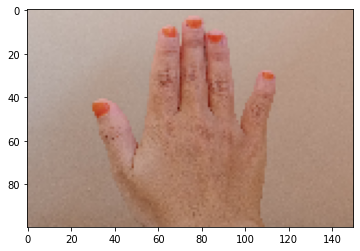

In [45]:
# Mengupload file ke google collabs
diupload = files.upload ()

for fig in diupload.keys() :
  # Memprediksikan gambar
  path = fig
  img_source = image.load_img(path, target_size = (img_width, img_height))
  imgplot = plt.imshow(img_source)
  x = image.img_to_array(img_source)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model_cnn.predict(images, batch_size = batch_size)
  
  print(fig)
  if classes[0, 0] == 1:
    print('Image category is paper')
  elif classes [0, 1] == 1:
    print('Image category is rock')
  elif classes[0, 2] == 1:
    print ('Image category is scissors')